## autoencoder + transformer to handle spatial and temporal information

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision import datasets, transforms, models
import matplotlib.image as image

import sys
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/utils')
sys.path.append('../../../src/DL')
from viz import show_images
from hdf5_dataset import hdf5_dataset
from build_model import VideoRegressionModel
from trainer import ModelTrainer

In [2]:
bs = 20
num_workers = 4

# imagenet
train_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_train.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels')
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

valid_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_test.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dl))
images, labels = batch
print(images.shape, labels.shape, labels)

torch.Size([20, 34, 1, 250, 400]) torch.Size([20, 3]) tensor([[0.2500, 0.3440, 0.3042],
        [0.5000, 0.6400, 0.3613],
        [0.2500, 0.7143, 0.0828],
        [0.2500, 0.6400, 0.4043],
        [0.2500, 0.3440, 0.3042],
        [0.2500, 0.8520, 0.1277],
        [0.5000, 0.6400, 0.3613],
        [0.2500, 0.0000, 0.0000],
        [0.2500, 0.3440, 0.3042],
        [0.2500, 0.8520, 0.1277],
        [0.2500, 0.3440, 0.3042],
        [0.0000, 0.6400, 0.4151],
        [0.2500, 0.8520, 0.1277],
        [0.0000, 0.6400, 0.4151],
        [0.2500, 1.0000, 0.8498],
        [0.7500, 0.6400, 0.3763],
        [0.7500, 0.6400, 0.3763],
        [0.2500, 1.0000, 0.8498],
        [1.0000, 0.6400, 0.3898],
        [0.2500, 1.0000, 0.8498]])


In [3]:
model = VideoRegressionModel(num_frames=34, num_channels=1, hidden_dim=512, num_layers=4, num_heads=8, mlp_dim=2048, output_dim=3)
gr, reconstructed = model(images)
print(gr.shape, reconstructed.shape)  # Should be (batch_size, output_dim)

torch.Size([20, 3]) torch.Size([20, 34, 1, 250, 400])


In [4]:
model.load_state_dict(torch.load('../../../datasets/MultiParams_ae_transformer/best_model.pt'))

<All keys matched successfully>

In [11]:
device = torch.device('cuda:0')
lr = 1e-3
start = 100
epochs = 400
model = nn.parallel.DataParallel(model, device_ids=[0, 1]).to(device)

def custom_loss_calculator(outputs, inputs, labels):
    losses = {}
    predictions, reconstructed = outputs

    loss_growth_rate = F.mse_loss(predictions, labels)
    loss_reconstruction = F.mse_loss(reconstructed, inputs)
    losses['loss_growth_rate'] = loss_growth_rate.item()
    losses['loss_reconstruction'] = loss_reconstruction.item()

    total_loss = loss_growth_rate + loss_reconstruction
    losses['Total_loss'] = total_loss

    return losses

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))

trainer = ModelTrainer(model, custom_loss_calculator, optimizer, device, scheduler)
history = trainer.train_epochs(train_dl, valid_dl_list=[valid_dl], valid_name_list=['validation'], save_per_epoch=20,
                               epochs=epochs, model_dir='../../../datasets/MultiParams_ae_transformer/')

Epoch: 1/400


100%|██████████| 703/703 [10:26:29<00:00, 53.47s/it] 


Training:
  loss_growth_rate: 0.0186
  loss_reconstruction: 0.0000
  Total_loss: 0.0187


100%|██████████| 55/55 [51:11<00:00, 55.84s/it]


validation:
  loss_growth_rate: 0.0104
  loss_reconstruction: 0.0061
  Total_loss: 0.0165
Epoch: 2/400


100%|██████████| 703/703 [10:52:55<00:00, 55.73s/it] 


Training:
  loss_growth_rate: 0.0187
  loss_reconstruction: 0.0000
  Total_loss: 0.0187


100%|██████████| 55/55 [56:19<00:00, 61.45s/it]


validation:
  loss_growth_rate: 0.0104
  loss_reconstruction: 0.0060
  Total_loss: 0.0164
Epoch: 3/400


100%|██████████| 703/703 [11:05:29<00:00, 56.80s/it]  


Training:
  loss_growth_rate: 0.0186
  loss_reconstruction: 0.0000
  Total_loss: 0.0187


100%|██████████| 55/55 [1:00:18<00:00, 65.79s/it]


validation:
  loss_growth_rate: 0.0099
  loss_reconstruction: 0.0056
  Total_loss: 0.0155
Epoch: 4/400


100%|██████████| 703/703 [12:51:33<00:00, 65.85s/it]  


Training:
  loss_growth_rate: 0.0186
  loss_reconstruction: 0.0000
  Total_loss: 0.0187


100%|██████████| 55/55 [1:05:21<00:00, 71.30s/it]


validation:
  loss_growth_rate: 0.0103
  loss_reconstruction: 0.0055
  Total_loss: 0.0158
Epoch: 5/400


100%|██████████| 703/703 [13:44:57<00:00, 70.41s/it]  


Training:
  loss_growth_rate: 0.0186
  loss_reconstruction: 0.0000
  Total_loss: 0.0187


100%|██████████| 55/55 [1:09:46<00:00, 76.12s/it]


validation:
  loss_growth_rate: 0.0099
  loss_reconstruction: 0.0061
  Total_loss: 0.0160
Epoch: 6/400


 34%|███▎      | 237/703 [4:36:23<9:24:36, 72.70s/it] 

## validation

In [6]:
bs = 4
num_workers = 0

# imagenet
train_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_train.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels')
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

valid_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_test.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dl))
images, labels = batch
print(images.shape, labels.shape, labels)

model = model.module

torch.Size([4, 34, 1, 250, 400]) torch.Size([4, 3]) tensor([[0.2500, 0.3440, 0.3042],
        [0.2500, 0.3440, 0.3042],
        [1.0000, 0.6400, 0.3898],
        [0.2500, 0.7143, 0.0828]])


In [7]:
torch.save(model.cpu().state_dict(), '../../../datasets/MultiParams_ae_transformer/best_model.pt')

In [ ]:
model.load_state_dict(torch.load('../../../datasets/growth_rate_ae_transformer_a100_lr1e-5/epoch-50.pt'))

<All keys matched successfully>

In [8]:
gr.shape

torch.Size([20, 3])

torch.Size([4, 3]) torch.Size([4, 3]) torch.Size([4, 34, 1, 250, 400]) torch.Size([4, 34, 1, 250, 400])


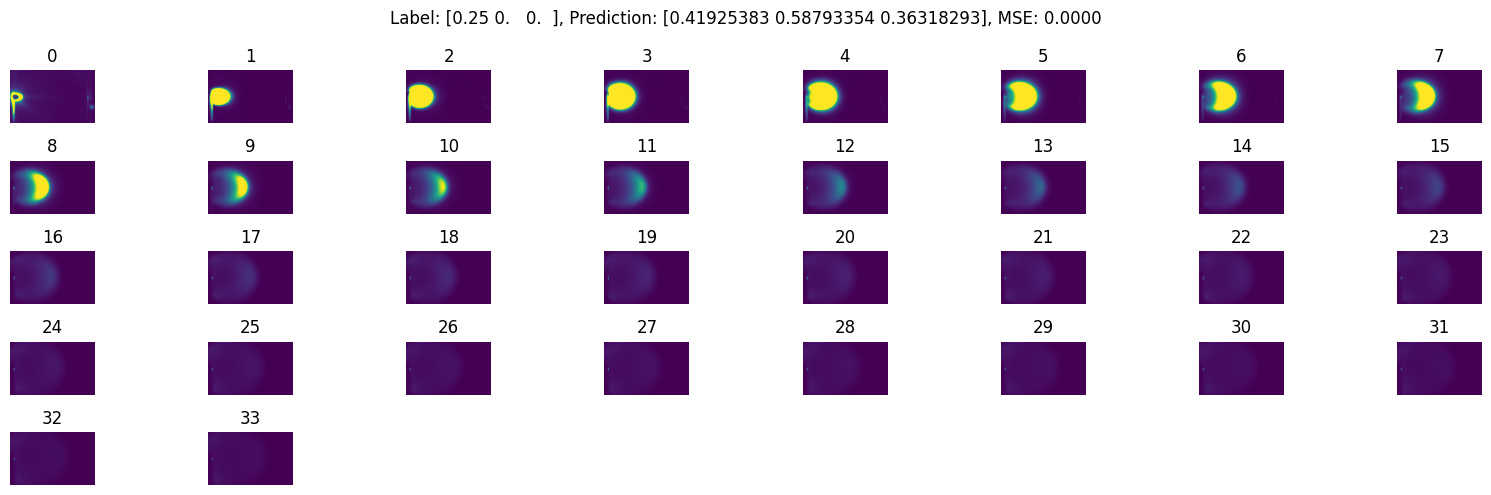

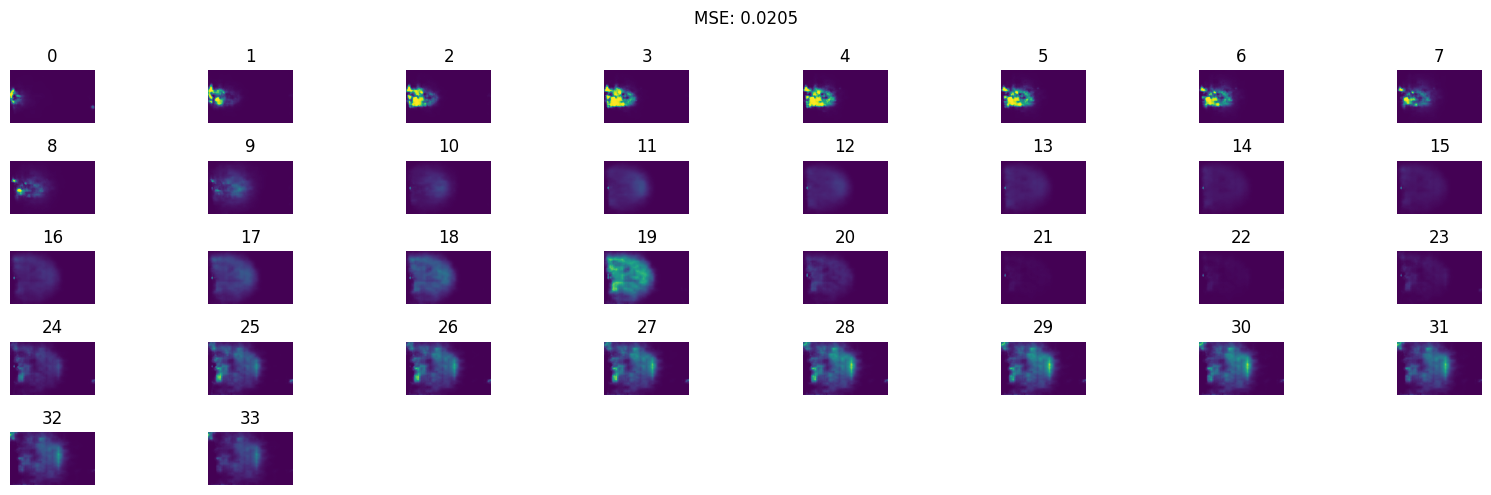

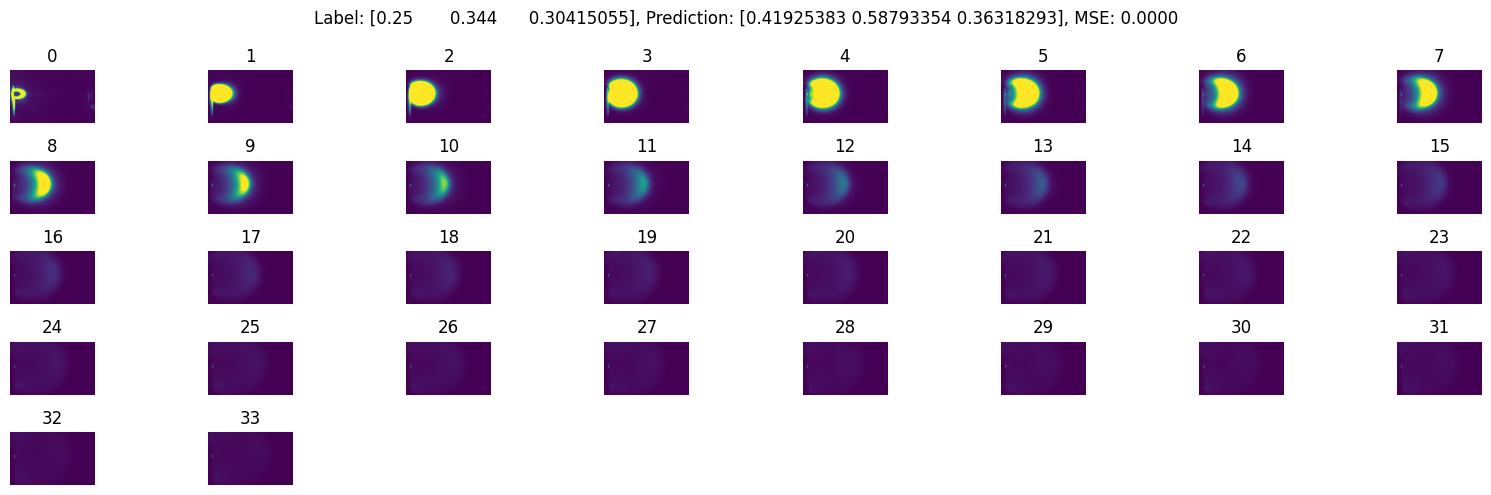

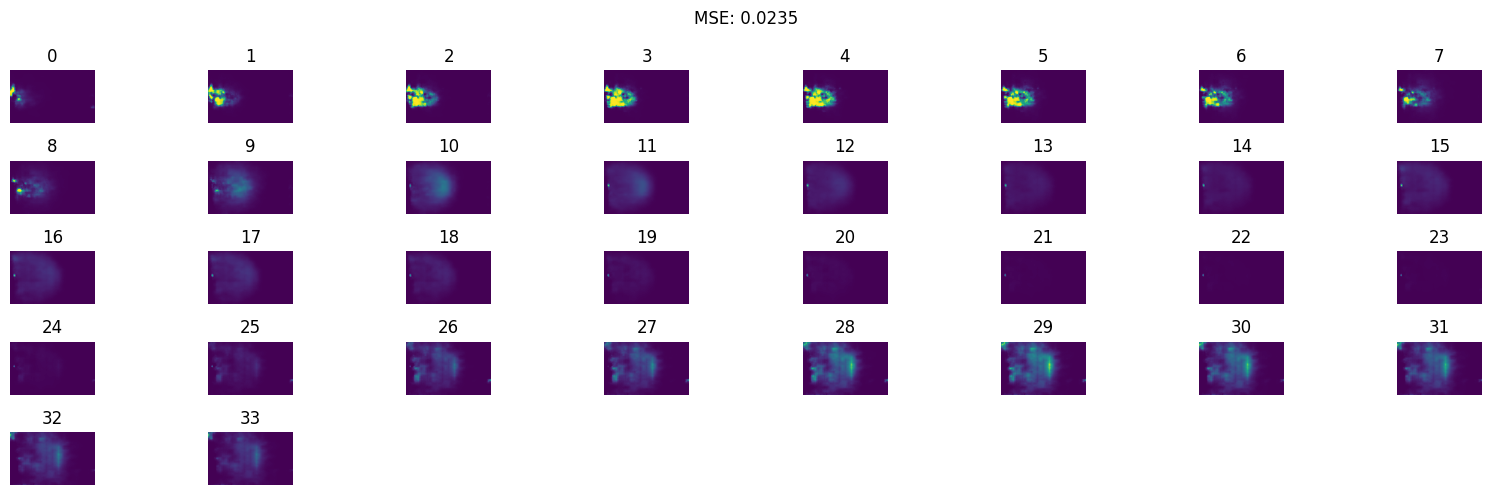

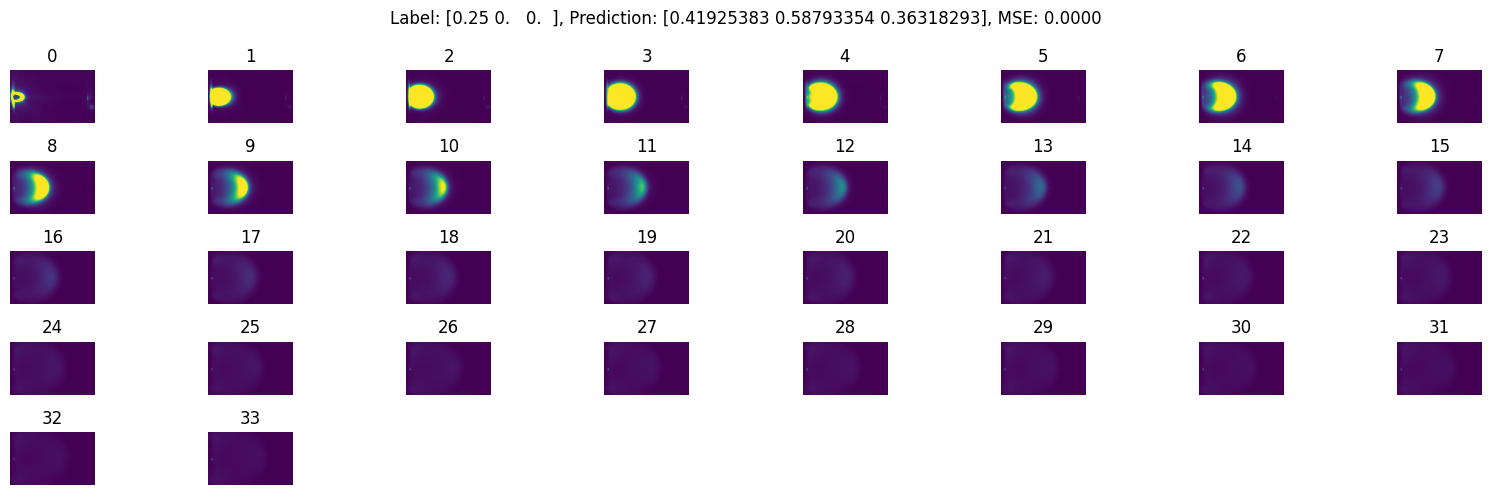

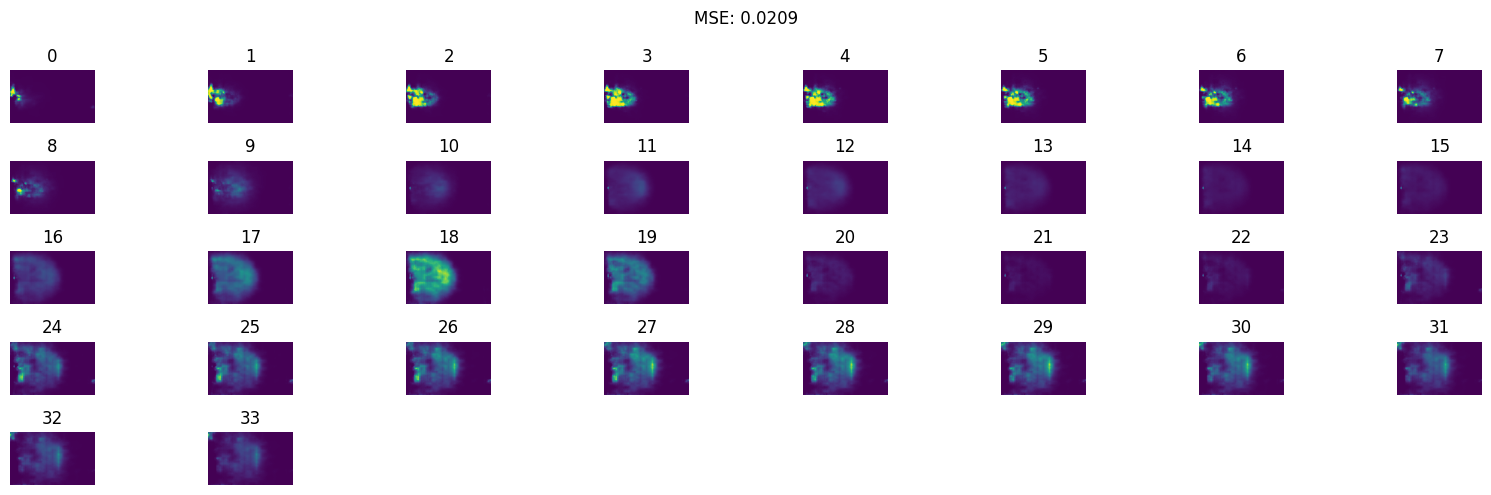

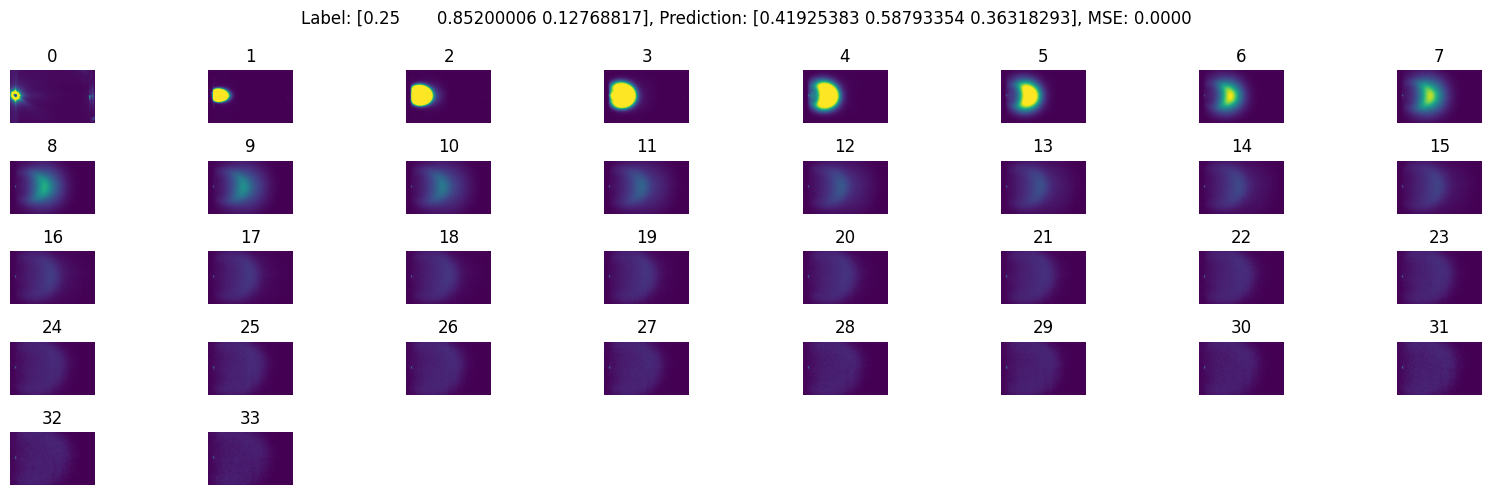

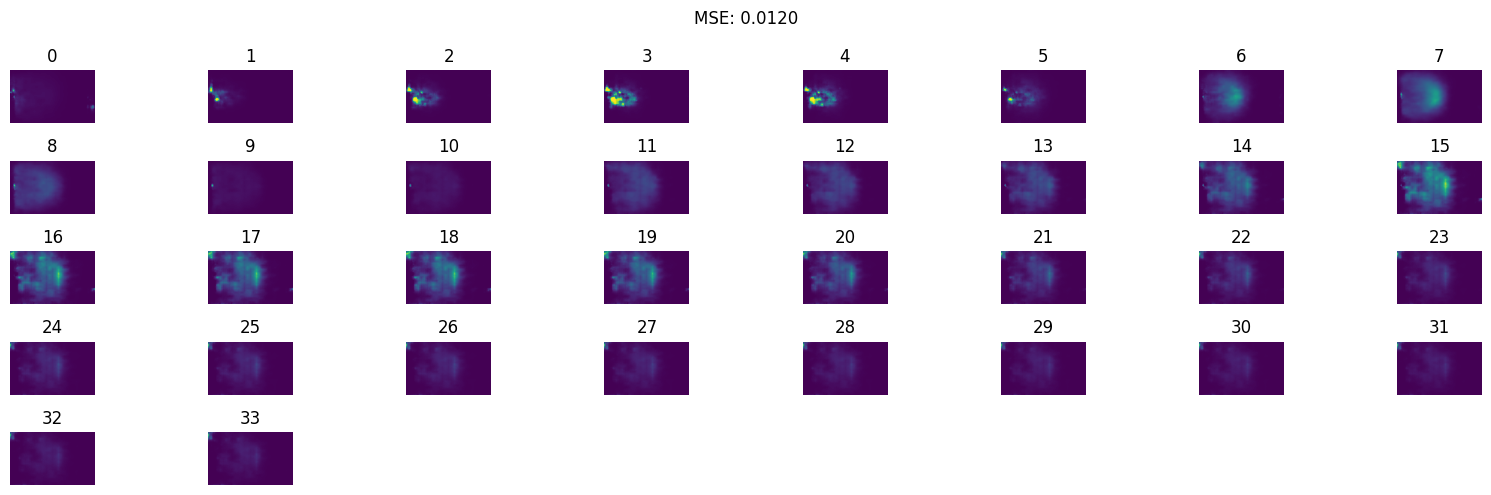

In [9]:
device = torch.device('cuda:0')
loss_func = nn.MSELoss()

batch = next(iter(train_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
preds, reconstructed = model(images)
# images = images.squeeze().cpu().detach().numpy()
# reconstructed = reconstructed.squeeze().cpu().detach().numpy()
print(labels.shape, labels.shape, images.shape, reconstructed.shape)

for i in range(len(images)):
    loss = loss_func(labels[i], labels[i]).item()
    pred = preds[i].cpu().detach().numpy()
    label = labels[i].cpu().detach().numpy()
    # print(loss, pred, label)
    show_images(images[i].squeeze().cpu().detach().numpy(), title=f'Label: {label}, Prediction: {pred}, MSE: {loss:.4f}')
    plt.show()
    loss_reconstruction = loss_func(reconstructed[i], images[i]).item()
    show_images(reconstructed.squeeze().detach().cpu().numpy()[i], title=f'MSE: {loss_reconstruction:.4f}')
    plt.show()

torch.Size([4, 3]) torch.Size([4, 3]) torch.Size([4, 34, 1, 250, 400]) torch.Size([4, 34, 1, 250, 400])


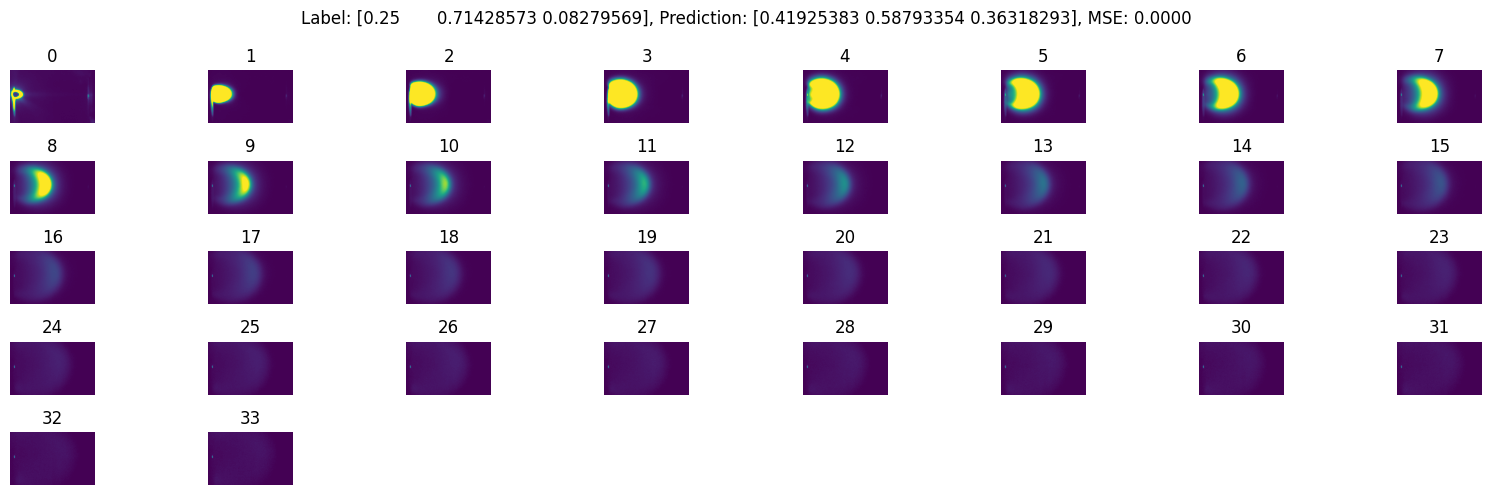

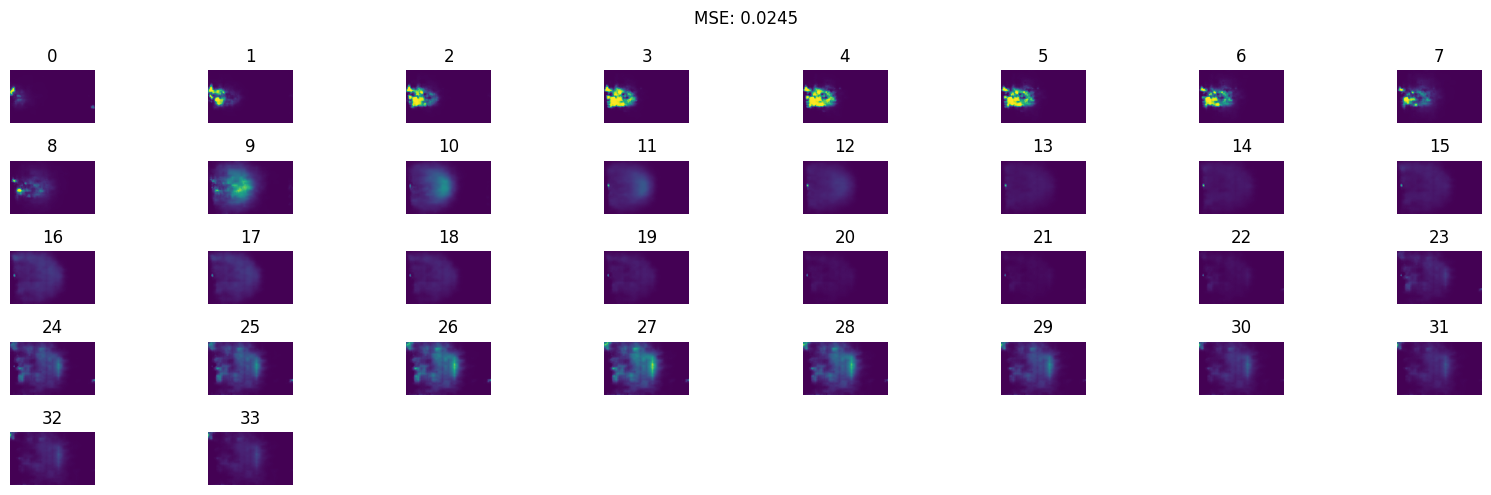

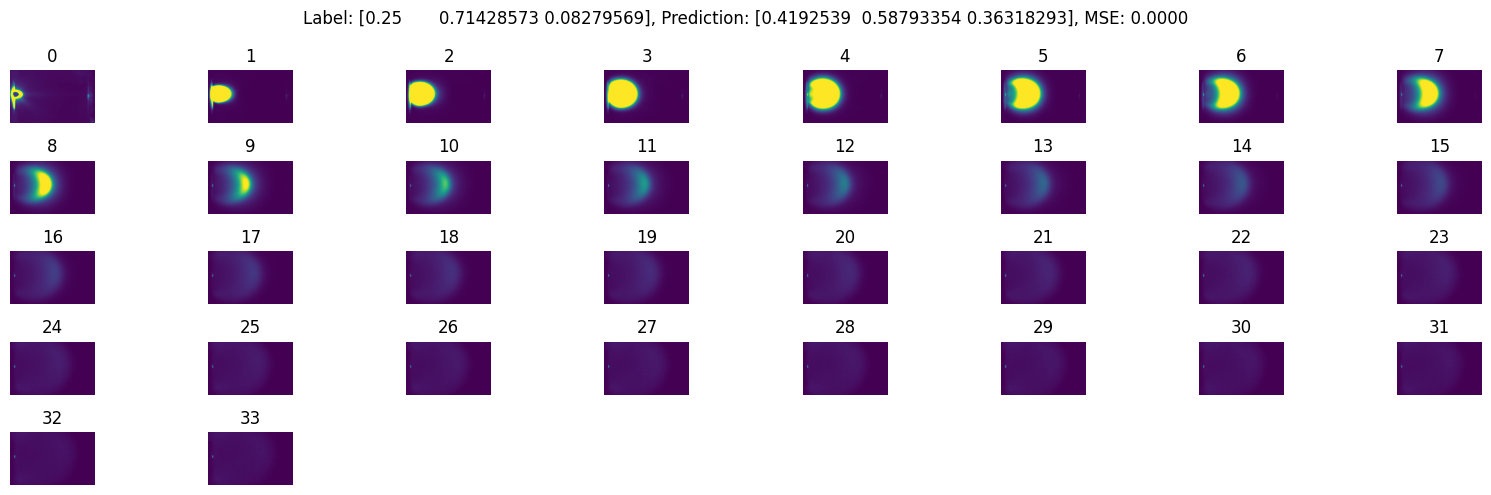

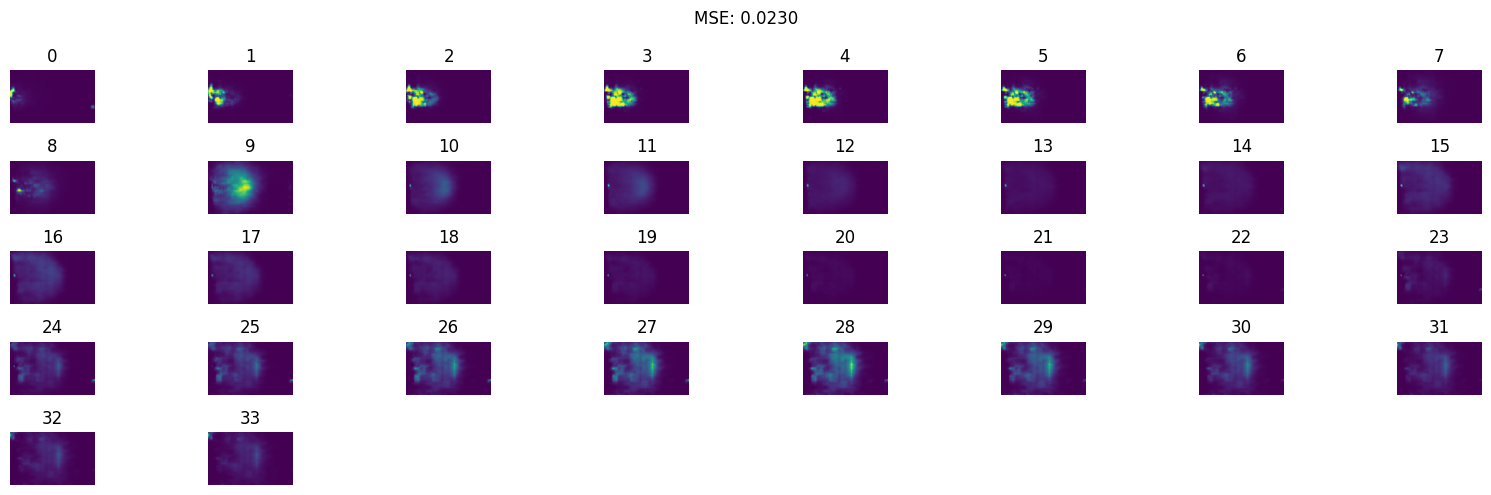

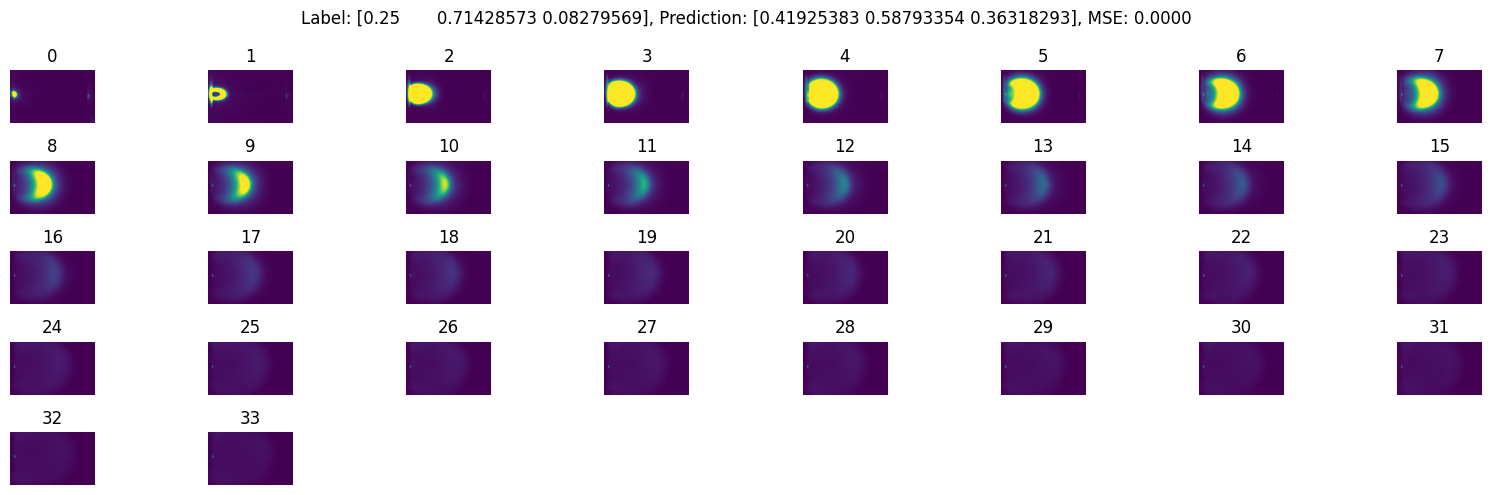

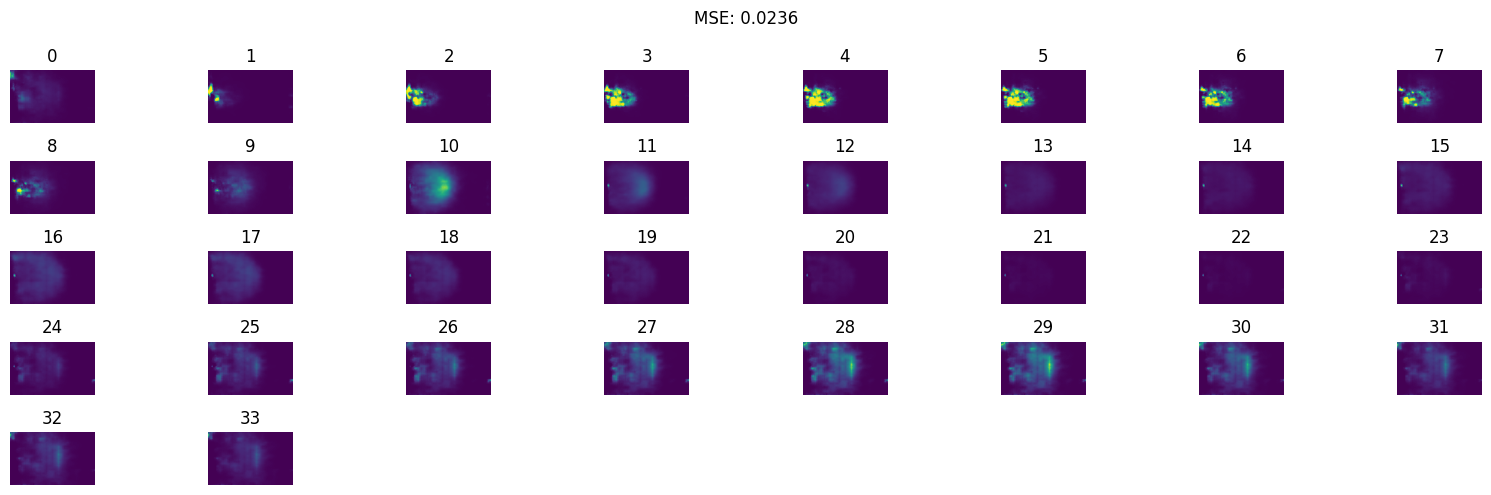

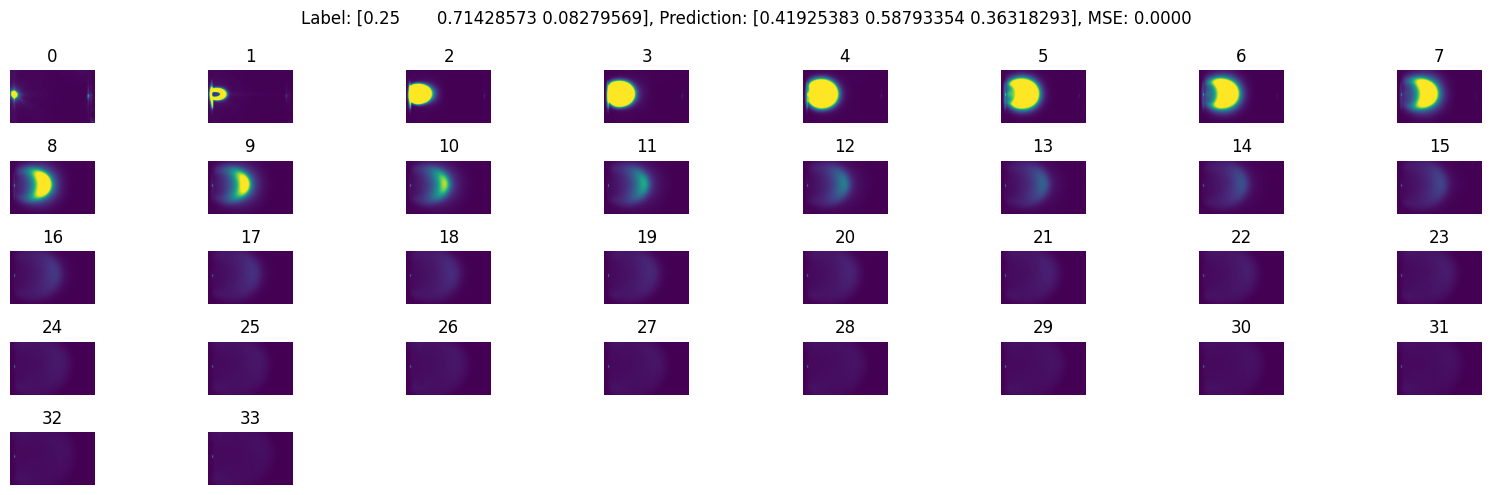

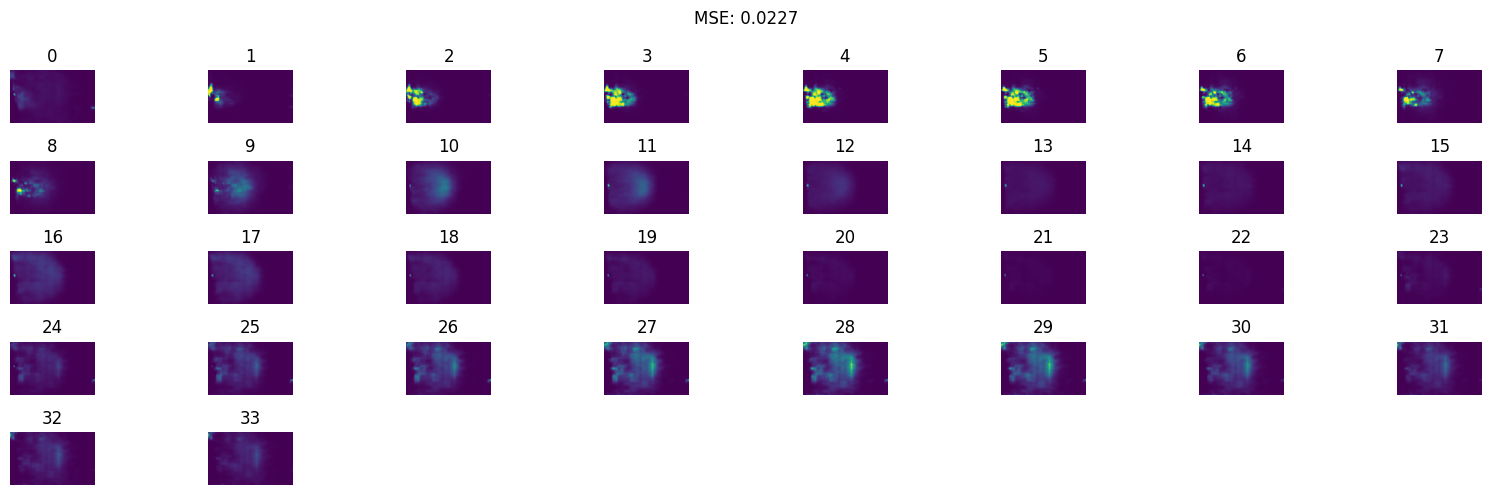

In [10]:
device = torch.device('cuda:0')
loss_func = nn.MSELoss()

batch = next(iter(valid_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
preds, reconstructed = model(images)
# images = images.squeeze().cpu().detach().numpy()
# reconstructed = reconstructed.squeeze().cpu().detach().numpy()
print(labels.shape, labels.shape, images.shape, reconstructed.shape)

for i in range(len(images)):
    loss = loss_func(labels[i], labels[i]).item()
    pred = preds[i].cpu().detach().numpy()
    label = labels[i].cpu().detach().numpy()
    # print(loss, pred, label)
    show_images(images[i].squeeze().cpu().detach().numpy(), title=f'Label: {label}, Prediction: {pred}, MSE: {loss:.4f}')
    plt.show()
    loss_reconstruction = loss_func(reconstructed[i], images[i]).item()
    show_images(reconstructed.squeeze().detach().cpu().numpy()[i], title=f'MSE: {loss_reconstruction:.4f}')
    plt.show()